In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [26]:
data = pd.read_csv("data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [27]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8820, 34)
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

   #not all models have predict_proba
    if callable(getattr(model, "predict_proba", None)):
        soft_predictions = model.predict_proba(test)[:,1]
        print("ROC AUC: "+str(roc_auc_score(truth,soft_predictions)))
    
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Attempt 2
---
## Issues with the first attempt
---
We found that our first attempt varied (in accuracy) greatly between different random test sets. This could indicate overfitting portions of the data. This could be due to a relatively small dataset size, which leads to the classifier not being able to really learn the correct things. 

---
## Improvement ideas
---
First, we will try to see if performance goes up if we try to train a "good frame" vs "bad frame" binary classifier, instead of a "good clip" vs "bad clip" binary classifier. The idea is that this will significantly increase the size of the dataset that we have available to us, helping the classifier generalize a bit more. 

If this yields improved results, we will then try to extend this concept of "good frames" vs "bad frames" by trying to create a basic composite score for each clip based on its proportion of good frames and bad frames. We can output this both as a soft score (the exact percentage of good vs bad) and as a hard score (if more good frames, we predict good clip, if more bad frames, we predict bad clip).

---
### Frame by Frame Classifier
---

In [29]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train,y_train)

Learning rate set to 0.022413
0:	learn: 0.6895287	total: 7.29ms	remaining: 7.28s
1:	learn: 0.6855700	total: 14.2ms	remaining: 7.09s
2:	learn: 0.6813467	total: 21.7ms	remaining: 7.21s
3:	learn: 0.6776662	total: 27.9ms	remaining: 6.96s
4:	learn: 0.6738570	total: 35.9ms	remaining: 7.15s
5:	learn: 0.6704721	total: 42ms	remaining: 6.96s
6:	learn: 0.6668553	total: 48.5ms	remaining: 6.88s
7:	learn: 0.6635260	total: 55.2ms	remaining: 6.84s
8:	learn: 0.6599371	total: 62.1ms	remaining: 6.84s
9:	learn: 0.6572203	total: 68.3ms	remaining: 6.76s
10:	learn: 0.6542176	total: 76.2ms	remaining: 6.85s
11:	learn: 0.6515229	total: 82.6ms	remaining: 6.8s
12:	learn: 0.6478251	total: 90.2ms	remaining: 6.85s
13:	learn: 0.6444805	total: 96.2ms	remaining: 6.78s
14:	learn: 0.6418386	total: 103ms	remaining: 6.77s
15:	learn: 0.6390064	total: 110ms	remaining: 6.76s
16:	learn: 0.6364788	total: 116ms	remaining: 6.72s
17:	learn: 0.6345809	total: 122ms	remaining: 6.68s
18:	learn: 0.6319841	total: 129ms	remaining: 6.65s


CATBOOST REV 2 STATS:
ACCURACY: 0.8934240362811792
ROC AUC: 0.961084879360953


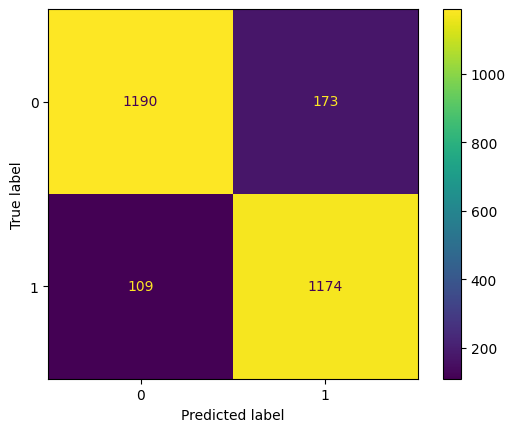

In [30]:
displayStats(cbm, "CATBOOST REV 2", X_test, y_test)

### Sanity Check

---

Let's generate a histogram of multiple CBTrees on different splits, and their respective statistics

In [33]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    data = pd.read_csv("data_nonconcat.csv",header=None)
    data = data.sample(frac=1)
    data = data.reset_index(drop=True)
    labels = data[0]
    data = data.drop(0,axis='columns')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.asarray(y_train.values.tolist())
    y_train = y_train.reshape(-1,1)
    y_test = np.asarray(y_test.values.tolist())
    y_test = y_test.reshape(-1,1)

    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train,y_train)

    predictions = cbm.predict(X_test) #all of them should have this
    print("ACCURACY: "+str(accuracy_score(y_test,predictions)))
    acc = accuracy_score(y_test,predictions)
    accuracies.append(acc)

print(accuracies)

ACCURACY: 0.8881330309901738


NameError: name 'truth' is not defined

### Conclusions of Frame by Frame classifier

---
The frame by frame classifier seems to do pretty well. We can now try to extend this concept to voting on each clip. 

---


### Attempt 1 at extending the frame-by-frame classification idea to classifying full clips

---

1. Import the concatenated vector data so that we have an entire clip as a row

In [200]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [201]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    74
1.0    73
Name: 0, dtype: int64
0.0    53
1.0    49
dtype: int64
1.0    24
0.0    21
dtype: int64


In [202]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)
CONCAT DATA SHAPES
(102, 2040)
(45, 2040)
(102, 1)
(45, 1)


2. Reshape to extract frame-by-frame 

In [203]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_C = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_C = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_C.shape)
print(X_test_C.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [204]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_C = np.repeat(y_train_C,(X_train_C.shape[0])/(y_train_C.shape[0]))
y_train_C = np.reshape(y_train_C,(-1,1))
y_test_C = np.repeat(y_test_C,(X_test_C.shape[0])/(y_test_C.shape[0]))
y_test_C = np.reshape(y_test_C,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


In [205]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train_C,y_train_C)

Learning rate set to 0.022329
0:	learn: 0.6891558	total: 5.62ms	remaining: 5.62s
1:	learn: 0.6852652	total: 11.5ms	remaining: 5.73s
2:	learn: 0.6809395	total: 16.8ms	remaining: 5.58s
3:	learn: 0.6768663	total: 21.5ms	remaining: 5.36s
4:	learn: 0.6729053	total: 26.2ms	remaining: 5.22s
5:	learn: 0.6695117	total: 31.4ms	remaining: 5.21s
6:	learn: 0.6656397	total: 38.4ms	remaining: 5.45s
7:	learn: 0.6618468	total: 44.6ms	remaining: 5.54s
8:	learn: 0.6582235	total: 50.4ms	remaining: 5.55s
9:	learn: 0.6554550	total: 55.1ms	remaining: 5.45s
10:	learn: 0.6524136	total: 59.1ms	remaining: 5.32s
11:	learn: 0.6498163	total: 63.8ms	remaining: 5.25s
12:	learn: 0.6469010	total: 68.1ms	remaining: 5.17s
13:	learn: 0.6439125	total: 72.2ms	remaining: 5.09s
14:	learn: 0.6411510	total: 77.2ms	remaining: 5.07s
15:	learn: 0.6380147	total: 82.5ms	remaining: 5.07s
16:	learn: 0.6354894	total: 87.1ms	remaining: 5.04s
17:	learn: 0.6330024	total: 92.7ms	remaining: 5.06s
18:	learn: 0.6299521	total: 97.9ms	remaining

CATBOOST REV 2 STATS:
ACCURACY: 0.6551851851851852
ROC AUC: 0.7096450617283951


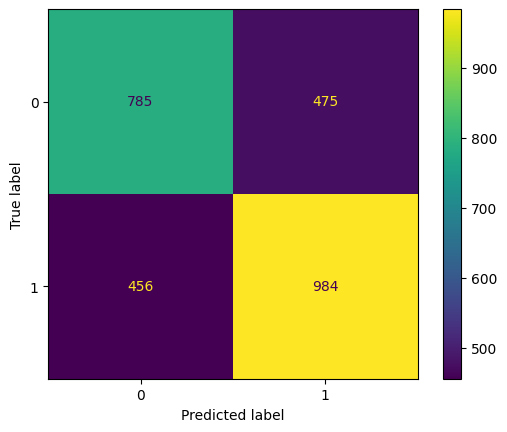

In [206]:
displayStats(cbm, "CATBOOST REV 2", X_test_C, y_test_C)